In [3]:
import pandas as pd
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
%%capture
!wget https://www.dropbox.com/s/0un1sdvifenp2ir/nyc-rolling-sales.csv

In [4]:
data = pd.read_csv('nyc-rolling-sales.csv')

#Удаление столбцов, не влияющих на обучение
del data["BLOCK"]
del data["LOT"]
del data["EASE-MENT"]
del data["ADDRESS"]
del data["APARTMENT NUMBER"]
del data["ZIP CODE"]
del data["Unnamed: 0"]
del data["TOTAL UNITS"]
#??????
#del data["SALE DATE"]

# Выбрасывание лишних данных
data = data[data['RESIDENTIAL UNITS'] < 100]
data = data[data['COMMERCIAL UNITS'] < 50]

#data = data[data["LAND SQUARE FEET"] != " -  "]
data["LAND SQUARE FEET"] = data["LAND SQUARE FEET"].replace(" -  ", 0)
data["LAND SQUARE FEET"] = pd.to_numeric(data["LAND SQUARE FEET"])
data["LAND SQUARE FEET"] = data["LAND SQUARE FEET"].replace(0, data["LAND SQUARE FEET"].mean())

data["GROSS SQUARE FEET"] = data["GROSS SQUARE FEET"].replace(" -  ", 0)
data["GROSS SQUARE FEET"] = pd.to_numeric(data["GROSS SQUARE FEET"])
data["GROSS SQUARE FEET"] = data["GROSS SQUARE FEET"].replace(0, data["GROSS SQUARE FEET"].mean())


#?????
data = data[data["YEAR BUILT"] > 1624]

#data["SALE DATE"] = data["SALE DATE"].str[:-12]
#data["SALE DATE"] = data["SALE DATE"].str[:3]
#data["SALE DATE"].unique()
#data["SALE DATE"] = pd.to_numeric(data["SALE DATE"])
#data = data[(data["SALE DATE"] > 1700) & (data["SALE DATE"] < 2022)]

data = data[data["SALE PRICE"] != " -  "]
data["SALE PRICE"] = pd.to_numeric(data["SALE PRICE"])
data = data[(data['SALE PRICE'] > 50000) & (data['SALE PRICE'] <= 3000000)]

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50004 entries, 13 to 84547
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         50004 non-null  int64  
 1   NEIGHBORHOOD                    50004 non-null  object 
 2   BUILDING CLASS CATEGORY         50004 non-null  object 
 3   TAX CLASS AT PRESENT            50004 non-null  object 
 4   BUILDING CLASS AT PRESENT       50004 non-null  object 
 5   RESIDENTIAL UNITS               50004 non-null  int64  
 6   COMMERCIAL UNITS                50004 non-null  int64  
 7   LAND SQUARE FEET                50004 non-null  float64
 8   GROSS SQUARE FEET               50004 non-null  float64
 9   YEAR BUILT                      50004 non-null  int64  
 10  TAX CLASS AT TIME OF SALE       50004 non-null  int64  
 11  BUILDING CLASS AT TIME OF SALE  50004 non-null  object 
 12  SALE PRICE                     

In [5]:
del data["SALE DATE"]

In [6]:
#Факторизация
column_names_fact = ['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
                     'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT',
                     'BUILDING CLASS AT TIME OF SALE']
# for col in column_names_fact:
#   data[col] = pd.factorize(data[col])[0]
data = pd.get_dummies(data, prefix=column_names_fact)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50004 entries, 13 to 84547
Columns: 548 entries, BOROUGH to BUILDING CLASS AT TIME OF SALE_Z9
dtypes: float64(2), int64(6), uint8(540)
memory usage: 29.2 MB


In [7]:
Y = data["SALE PRICE"]
X = data.drop(["SALE PRICE"], axis = 1)
train_points, test_points, train_values, test_values = train_test_split(X, Y, test_size = 0.2)

In [8]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(train_points, train_values)
rf_predict = rf_model.predict(test_points)
print(mean_absolute_error(test_values, rf_predict))

214792.41949788952


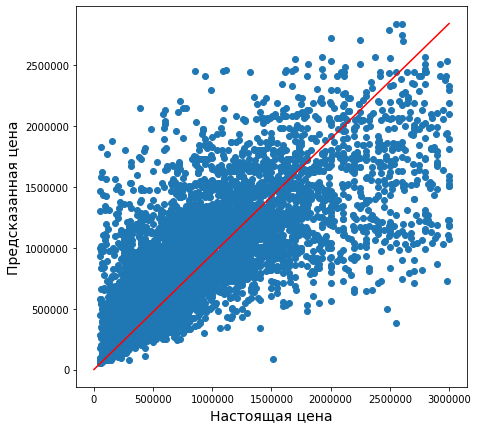

In [11]:
plt.figure(figsize=(7, 7))
plt.scatter(test_values, rf_predict) 
plt.plot([0, max(test_values)], [0, max(rf_predict)], 'r')
plt.xlabel('Настоящая цена', fontsize=14)
plt.ylabel('Предсказанная цена', fontsize=14);

In [12]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(train_points, train_values)
xgb_predict = xg_reg.predict(test_points)
print(mean_absolute_error(test_values, xgb_predict))

254536.04213641136


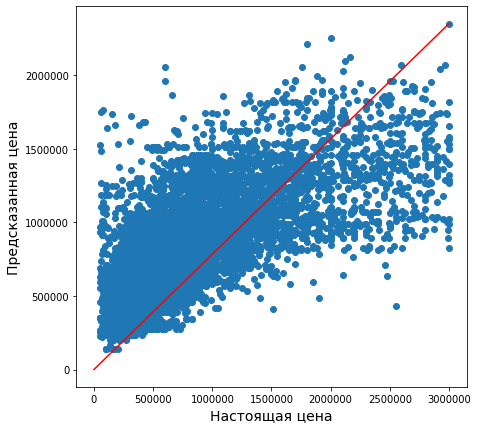

In [14]:
plt.figure(figsize=(7, 7))
plt.scatter(test_values, xgb_predict)
plt.plot([0, max(test_values)], [0, max(xgb_predict)], 'r')
plt.xlabel('Настоящая цена', fontsize=14)
plt.ylabel('Предсказанная цена', fontsize=14);

In [15]:
nn_model = Sequential()
nn_model.add(Dense(17, activation='relu'))
nn_model.add(Dense(15, activation='relu'))
nn_model.add(Dense(15, activation='relu'))
nn_model.add(Dense(1))

nn_model.compile(loss='mean_absolute_error', optimizer='adam')

results = nn_model.fit(
 train_points, train_values,
 epochs= 20,
 batch_size = 100,
 validation_data = (test_points, test_values)
)

nn_predict = nn_model.predict(test_points)
print(mean_absolute_error(test_values, nn_predict))

Epoch 1/20
401/401 [==============================] - 2s 3ms/step - loss: 687080.7584 - val_loss: 417723.3438
Epoch 2/20
401/401 [==============================] - 1s 2ms/step - loss: 381817.9781 - val_loss: 412970.1875
Epoch 3/20
401/401 [==============================] - 1s 2ms/step - loss: 378778.9704 - val_loss: 408386.1562
Epoch 4/20
401/401 [==============================] - 1s 2ms/step - loss: 377821.7247 - val_loss: 403970.2500
Epoch 5/20
401/401 [==============================] - 1s 2ms/step - loss: 376034.2631 - val_loss: 403012.7500
Epoch 6/20
401/401 [==============================] - 1s 2ms/step - loss: 377501.7066 - val_loss: 399351.9375
Epoch 7/20
401/401 [==============================] - 1s 2ms/step - loss: 372326.9763 - val_loss: 397291.4062
Epoch 8/20
401/401 [==============================] - 1s 2ms/step - loss: 373704.6283 - val_loss: 396321.3750
Epoch 9/20
401/401 [==============================] - 1s 2ms/step - loss: 372195.7250 - val_loss: 395817.9375
Epoch 10/2

c:\users\starover\envs\datascience\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


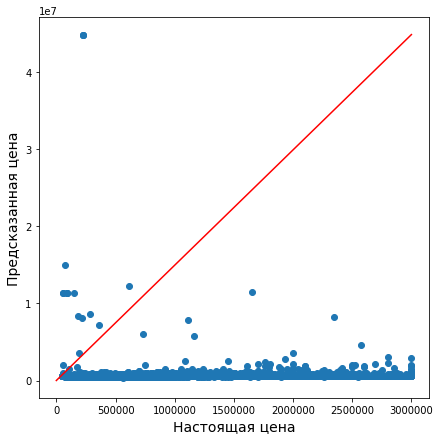

In [16]:
plt.figure(figsize=(7, 7))
plt.scatter(test_values, nn_predict)
plt.plot([0, max(test_values)], [0, max(nn_predict)], 'r')
plt.xlabel('Настоящая цена', fontsize=14)
plt.ylabel('Предсказанная цена', fontsize=14);

In [17]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_points, train_values)
lr_predict = model.predict(test_points)
print(mean_absolute_error(test_values, lr_predict))

254137.2419038055


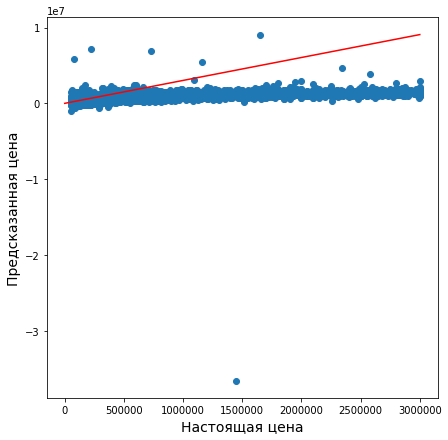

In [19]:
plt.figure(figsize=(7, 7))
plt.scatter(test_values, lr_predict)
plt.plot([0, max(test_values)], [0, max(lr_predict)], 'r')
plt.xlabel('Настоящая цена', fontsize=14)
plt.ylabel('Предсказанная цена', fontsize=14);

In [20]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(train_points, train_values)
xgb_predict = xg_reg.predict(test_points)
print(mean_absolute_error(test_values, xgb_predict))

254536.04213641136


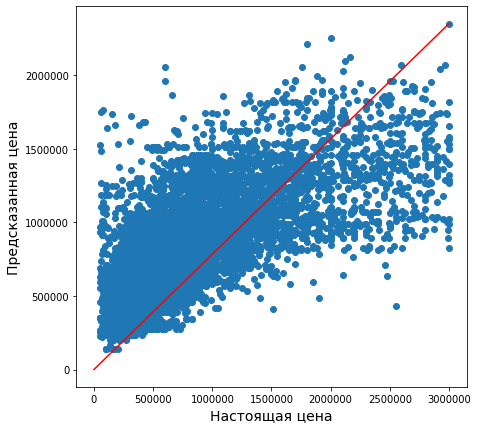

In [21]:
plt.figure(figsize=(7, 7))
plt.scatter(test_values, xgb_predict)
plt.plot([0, max(test_values)], [0, max(xgb_predict)], 'r')
plt.xlabel('Настоящая цена', fontsize=14)
plt.ylabel('Предсказанная цена', fontsize=14);